# Operation Identification using Deep Learning (BERT)
##### Since the accuracy on unseen data was previously low(48%), I'm going to combine both the datasets(singleop.json and SVAMP.json) and see if it gets any better!

1. Make all samples equally probable
2. Just join and see

# 1 Import and Combine Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
so = pd.read_csv('cleaned_singleop.csv')
sv = pd.read_csv('cleaned_svamp.csv')

In [3]:
so = so[['Type', 'Clean']]
so.head()

Type                                              Clean
0  Addition  if there are bottle caps in a box and linda pu...
1  Addition  jose starts with bottle caps he gets more from...
2  Addition  bridget has skittles henry has skittles if hen...
3  Addition  brenda starts with skittles she buys more how ...
4  Addition  there are cards cards more are added how many ...

In [4]:
sv = sv[['Type', 'Clean']]
len(sv)

1000

In [5]:
df = pd.concat([sv, so])
df = df.sort_values('Clean')
df

Type                                              Clean
398  Multiplication          a bee has legs how many legs do bees have
295  Multiplication          a bee has legs how many legs do bees have
729     Subtraction  a book has chapters across pages the first cha...
717     Subtraction  a book has chapters across pages the second ch...
445  Multiplication  a book has chapters each chapter is pages long...
..              ...                                                ...
360     Subtraction  zachary did pushups and david did pushups in g...
365        Addition  zachary did pushups in gym class today david d...
469     Subtraction  zachary did pushups in gym class today david d...
460        Addition  zachary did pushups in gym class today david d...
239     Subtraction  zachary did pushups in gym class today david d...

[1562 rows x 2 columns]

<AxesSubplot:>

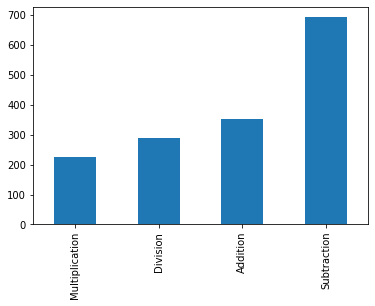

In [6]:
df.Type.value_counts().sort_values().plot(kind = 'bar')

# 2. Build Model
4 classes are ['Addition','Division', 'Multiplication', 'Subtraction']

In [7]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

## 2.1 Encode the Labels

In [8]:
possible_labels = df.Type.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Multiplication': 0, 'Subtraction': 1, 'Addition': 2, 'Division': 3}

In [9]:
df['label'] = df.Type.replace(label_dict)

## 2.2 Train & Validation Split
#### Since the data is very imbalanced, I'm splitting the dataset into a stratified way.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                 df.label.values,
                                                 test_size=0.15,
                                                 random_state=42,
                                                 stratify=df.label.values)

In [12]:
# check how many of each were selected
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['Type', 'label', 'data_type']).count()

Clean
Type           label data_type       
Addition       2     train        267
                     val           87
Division       3     train        218
                     val           72
Multiplication 0     train        167
                     val           58
Subtraction    1     train        531
                     val          162

## 2.3 BERT TOKENIZER and ENCODING

- Constructs a BERT tokenizer. Based on WordPiece.
- Instantiate a pre-trained BERT model configuration to encode our data.
- To convert all the titles from text into encoded form, we use a function called batch_encode_plus , and we will proceed train and validation data separately.
- The 1st parameter inside the above function is the title text.
- add_special_tokens=True means the sequences will be encoded with the special tokens relative to their model.
- When batching sequences together, we set return_attention_mask=True, so it will return the attention mask according to the specific tokenizer defined by the max_length attribute.
- We also want to pad all the titles to certain maximum length.
- We actually do not need to set max_length=256, but just to play it safe.
- return_tensors='pt' to return PyTorch.
- And then we need to split the data into input_ids, attention_masks and labels.
- Finally, after we get encoded data set, we can create training data and validation data.

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].Clean.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].Clean.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

# train
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

# validation
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\d3583\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:2300: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## 2.4 BERT Pre-trained Model
Treat each title as unique seq, so one seq is classified to one of the labels (Operations)
- bert-base-uncased is smaller pre-trained model (still huge, 440MB omg)
- num_labels = # output labels
- don't care about output_attentions & output_hidden_states

In [14]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## 2.5 Data Loaders
Makes an iterable over given dataset by combining dataset and sampler.
RandomSampler - training
SequentialSampler - for validation

adjust batch_size based on memory available!

In [31]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

## 2.6 Optimizer & Scheduler
To construct an optimizer, we have to give it an iterable containing the parameters to optimize. Then, we can specify optimizer-specific options such as the learning rate, epsilon, etc.
I found epochs=5 works well for this data set.
Create a schedule with a learning rate that decreases linearly from the initial learning rate set in the optimizer to 0, after a warmup period during which it increases linearly from 0 to the initial learning rate set in the optimizer.

In [32]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 2

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

## 2.7 Performance Metrics
F1 & Accuracy

In [45]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}')
        acc = (len(y_preds[y_preds==label])/len(y_true))*100
        print(f'Accuracy in %: {acc}\n')

# 3. Training Loop

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [36]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

    

In [37]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'ep2finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')    

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/395 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.6815182261829135
Validation loss: 0.5796847866158786
F1 Score (Weighted): 0.7793015584486337


Epoch 2:   0%|          | 0/395 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.46514586487997184
Validation loss: 0.484202607952821
F1 Score (Weighted): 0.8314800440854269


## 4. Load and Evaluate Model

In [43]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [47]:
model.load_state_dict(torch.load('ep2finetuned_BERT_epoch_2.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Class: Multiplication
Accuracy: 41/58
Accuracy in %: 70.6896551724138

Class: Subtraction
Accuracy: 143/162
Accuracy in %: 88.27160493827161

Class: Addition
Accuracy: 70/87
Accuracy in %: 80.45977011494253

Class: Division
Accuracy: 61/72
Accuracy in %: 84.72222222222221

